## Import Package

In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

# dataset
import math
import glob
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, Subset, DataLoader
import matplotlib.pyplot as plt

# save result
import pickle

In [2]:
torch.manual_seed(2022)
try:
    device = torch.device("mps")
except:
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
device

device(type='mps')

## Prepare Dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!unzip "/gdrive/MyDrive/Colab Notebooks/Kaggle/CIFAR-10 - Object Recognition in Images/cifar-10.zip"
!7z x train.7z
!7z x test.7z

### Calculate Channel Mean and Standard Deviation

In [ ]:
img_names = glob.glob(f"cifar-10/train/*.png")

In [ ]:
img_names[0:10]

In [ ]:
imgs = []

transform = transforms.Compose([
    transforms.ToTensor(),
])

for img in img_names:
    img = Image.open(img)
    imgs.append(transform(img))

In [ ]:
imgs = torch.stack(imgs, dim=3)
channel_mean = imgs.view(3, -1).mean(dim=1)
channel_std = imgs.view(3, -1).std(dim=1)
print(f"channel mean: {channel_mean}")
print(f"channel std: {channel_std}")

### Create Custom Dataset

In [4]:
class CIFARDataset(Dataset):

    def __init__(self, img_path, transform, csv_path):
        self.csv_path = csv_path
        self.transform = transform
        
        if csv_path:
            self.img_names = glob.glob(f"{img_path}/*.png")
        else:
            self.img_names = [f"{img_path}/{idx}.png" for idx in range(1, 300001)]

        if csv_path:
            label_df = pd.read_csv(csv_path)
            self.label_idx2name = label_df['label'].unique()
            self.label_name2idx = {}
            for i in range(len(self.label_idx2name)):
                self.label_name2idx[self.label_idx2name[i]] = i
            self.img2label = {}
            for _, row in label_df.iterrows():
                self.img2label[f"{img_path}/{row['id']}.png"] = self.label_name2idx[row['label']]
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, index):
        img = self.img_names[index]

        if self.csv_path:
            label = self.img2label[img]
            label = torch.tensor(label)
        else:
            label = -1
        
        img = Image.open(img)
        img = self.transform(img)
        return (img, label)

In [ ]:
transform_fn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=channel_mean,
        std=channel_std
    )
])

In [5]:
# transform_fn for pretrained DenseNet
channel_mean = torch.Tensor([0.485, 0.456, 0.406])
channel_std = torch.Tensor([0.229, 0.224, 0.225])

transform_fn = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=channel_mean, std=channel_std),
])

In [6]:
dataset = CIFARDataset(
    img_path="cifar-10/train",
    transform=transform_fn,
    csv_path="cifar-10/trainLabels.csv",
)

### Split `dataset` into `train_dataset` and `valid_dataset`

In [7]:
indexes = list(range(len(dataset)))
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.2)
train_dataset = Subset(dataset, train_indexes)
valid_dataset = Subset(dataset, valid_indexes)

print(f"number of samples in train_dataset: {len(train_dataset)}")
print(f"number of samples in valid_dataset: {len(valid_dataset)}")

number of samples in train_dataset: 40000
number of samples in valid_dataset: 10000


### Create DataLoader

In [8]:
train_valid_dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=32,
    shuffle=True
)

### Show Some Samples in Batch

In [9]:
def show_samples(batch_img, batch_label=None, num_samples=16):

    sample_idx = 0
    total_col = 4
    total_row = math.ceil(num_samples / 4)
    col_idx = 0
    row_idx = 0

    fig, axs = plt.subplots(total_row, total_col, figsize=(15, 15))

    while sample_idx < num_samples:
        img = batch_img[sample_idx]
        img = img.view(3, -1) * channel_std.view(3, -1) + channel_mean.view(3, -1)
        img = img.view(3, 224, 224)
        img = img.permute(1, 2, 0)
        axs[row_idx, col_idx].imshow(img)

        if batch_label != None:
            axs[row_idx, col_idx].set_title(dataset.label_idx2name[(batch_label[sample_idx])])

        sample_idx += 1
        col_idx += 1
        if col_idx == 4:
            col_idx = 0
            row_idx += 1

In [10]:
batch_img, batch_label = next(iter(train_dataloader))

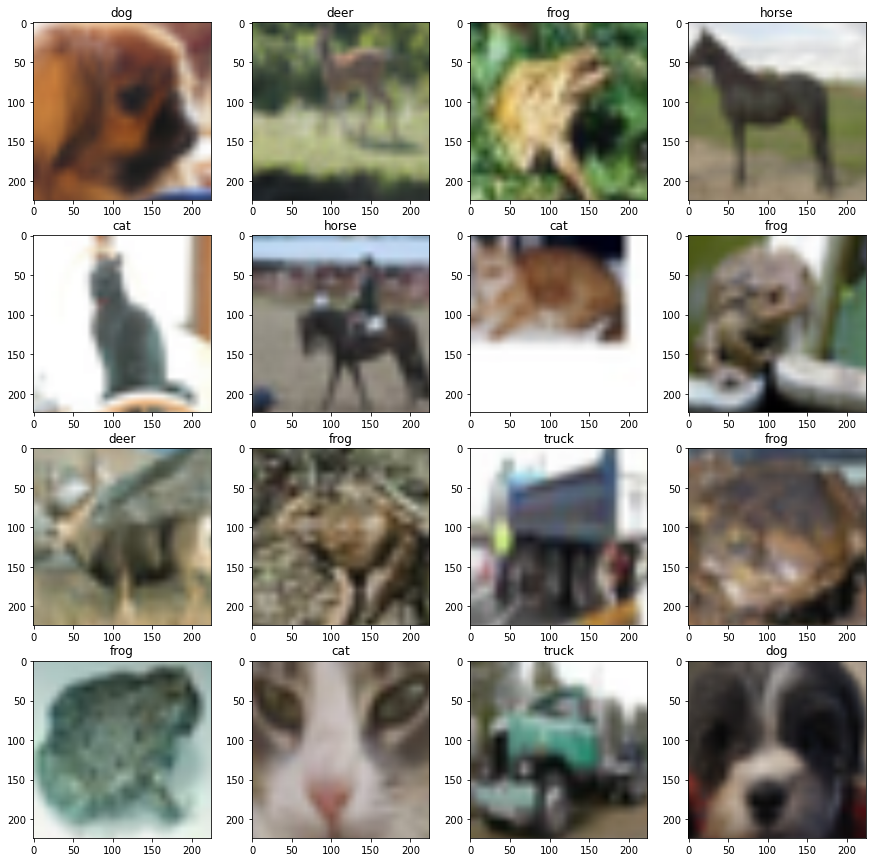

In [11]:
show_samples(batch_img, batch_label, 16)

## Build Model

### Vallina CNN

In [ ]:
class VallinaCNN(nn.Module):

    def __init__(self):
        super(VallinaCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.linear1 = nn.Linear(64*8*8, 10)


    def forward(self, inp):
        x = F.relu(self.conv1(inp))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        out = self.linear1(x)

        return out

In [ ]:
class CNNDropout(nn.Module):

    def __init__(self):
        super(CNNDropout, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout(p=0.4)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout(p=0.4)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.linear1 = nn.Linear(64*8*8, 10)


    def forward(self, inp):
        x = F.relu(self.conv1(inp))
        x = F.max_pool2d(x, (2, 2))
        x = self.conv1_dropout(x)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = self.conv2_dropout(x)

        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        out = self.linear1(x)

        return out

In [ ]:
class CNNBatchNorm(nn.Module):

    def __init__(self):
        super(CNNBatchNorm, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(num_features=16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(num_features=32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(num_features=64)
        self.linear1 = nn.Linear(64*8*8, 10)


    def forward(self, inp):
        x  = self.conv1(inp)
        x = self.conv1_bn(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))

        x  = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))

        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = F.relu(x)
        
        x = torch.flatten(x, 1)
        out = self.linear1(x)

        return out

In [ ]:
class ResBlock(nn.Module):

    def __init__(self, num_in_channel, num_out_channel):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=num_in_channel, out_channels=num_out_channel, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=num_out_channel)

        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity="relu")
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

class ResNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.resblock1 = ResBlock(num_in_channel=32, num_out_channel=32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.resblock2 = ResBlock(num_in_channel=64, num_out_channel=64)
        self.fc1 = nn.Linear(1024, 10)
        # self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, 2)
        out = self.resblock1(out)
        out = F.max_pool2d(out, 2)
        out = self.conv2(out)
        out = self.resblock2(out)
        out = F.max_pool2d(out, 2)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        # out = self.fc2(out)
        return out

In [12]:
class PretrainDenseNet(nn.Module):

    def __init__(self):
        super(PretrainDenseNet, self).__init__()
        model = models.densenet121(pretrained=True)
        num_classifier_feature = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_classifier_feature, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )
        self.model = model

        # for param in self.model.named_parameters():
        #     if 'features' in param[0]:
        #         param[1].requires_grad = False

    def forward(self, x):
        return self.model(x)

In [ ]:
# net = VallinaCNN()
# net = CNNDropout()
# net = CNNBatchNorm()
# net = ResNet()
net = PretrainDenseNet()
net.to(device)
print(f"number of paramaters: {sum([param.numel() for param in net.parameters() if param.requires_grad])}")

## Train Model

### Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005)

In [ ]:
def cross_entropy_loss_with_l2_reg(pred, label, model):
    ce_loss = nn.CrossEntropyLoss()
    loss = ce_loss(pred, label)

    l2_lambda = 0.001
    l2_norm = sum([p.pow(2.0).sum() for p in model.parameters()])
    return loss + l2_lambda*l2_norm

In [ ]:
criterion_l2reg = cross_entropy_loss_with_l2_reg

### Training Loop 

In [ ]:
def get_accuracy(output, label):
    output = output.to("cpu")
    label = label.to("cpu")

    sm = F.softmax(output, dim=1)
    _, index = torch.max(sm, dim=1)
    return torch.sum((label == index)) / label.size()[0]

In [ ]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    total_loss = 0.0
    running_acc = 0.0
    total_acc = 0.0

    for batch_idx, (batch_img, batch_label) in enumerate(dataloader):

        batch_img = batch_img.to(device)
        batch_label = batch_label.to(device)

        optimizer.zero_grad()
        output = net(batch_img)
        loss = criterion(output, batch_label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_loss += loss.item()

        acc = get_accuracy(output, batch_label)
        running_acc += acc
        total_acc += acc

        if batch_idx % 500 == 0 and batch_idx != 0:
            print(f"[step: {batch_idx:4d}] loss: {running_loss / 500:.3f}")
            running_loss = 0.0
            running_acc = 0.0
    
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [ ]:
def validate(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    for batch_idx, (batch_img, batch_label) in enumerate(dataloader):

        batch_img = batch_img.to(device)
        batch_label = batch_label.to(device)

        # optimizer.zero_grad()
        output = net(batch_img)
        loss = criterion(output, batch_label)
        # loss.backward()
        # optimizer.step()

        total_loss += loss.item()
        acc = get_accuracy(output, batch_label)
        total_acc += acc
    
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [ ]:
EPOCHS = 5
train_history = []
valid_history = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(net, train_dataloader)
    valid_loss, valid_acc = validate(net, valid_dataloader)
    print(f"Epoch: {epoch:2d}, training loss: {train_loss:.3f}, training acc: {train_acc:.3f} validation loss: {valid_loss:.3f}, validation acc: {valid_acc:.3f}")

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    if valid_loss <= min(valid_history):
        torch.save(net.state_dict(), "net.pt")

In [7]:
with open("log/VallinaCNN_train_loss", "rb") as fp:
    train_history_vcnn = pickle.load(fp)

with open("log/VallinaCNN_valid_loss", "rb") as fp:
    valid_history_vcnn = pickle.load(fp)

with open("log/CNNDropout_train_loss", "rb") as fp:
    train_history_cnnd = pickle.load(fp)

with open("log/CNNDropout_valid_loss", "rb") as fp:
    valid_history_cnnd = pickle.load(fp)

with open("log/CNNBN_train_loss", "rb") as fp:
    train_history_cnnb = pickle.load(fp)

with open("log/CNNBN_valid_loss", "rb") as fp:
    valid_history_cnnb = pickle.load(fp)

with open("log/DenseNet_train_loss", "rb") as fp:
    train_history_dn = pickle.load(fp)

with open("log/DenseNet_valid_loss", "rb") as fp:
    valid_history_dn = pickle.load(fp)

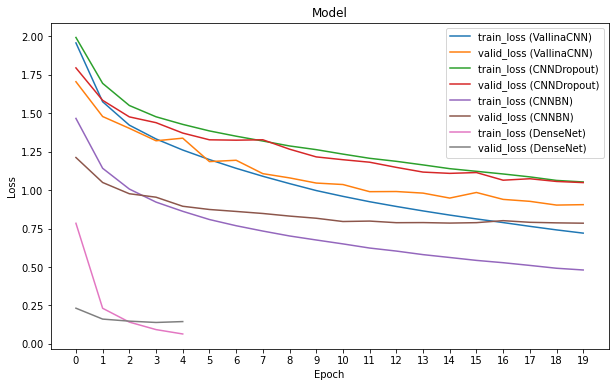

In [8]:
plt.figure(figsize=(10, 6))
plt.title("Model")
plt.xlabel("Epoch")
plt.xticks(list(range(0, 20)))
plt.ylabel("Loss")
plt.plot(train_history_vcnn, label="train_loss (VallinaCNN)")
plt.plot(valid_history_vcnn, label="valid_loss (VallinaCNN)")
plt.plot(train_history_cnnd, label="train_loss (CNNDropout)")
plt.plot(valid_history_cnnd, label="valid_loss (CNNDropout)")
plt.plot(train_history_cnnb, label="train_loss (CNNBN)")
plt.plot(valid_history_cnnb, label="valid_loss (CNNBN)")
plt.plot(train_history_dn, label="train_loss (DenseNet)")
plt.plot(valid_history_dn, label="valid_loss (DenseNet)")
plt.legend()

In [ ]:
with open("DenseNet_train_loss", "wb") as fp:
    pickle.dump(train_history, fp)

with open("DenseNet_valid_loss", "wb") as fp:
    pickle.dump(valid_history, fp)

## Predict on Test Dataset and Submit to Kaggle

In [13]:
net = PretrainDenseNet()
net.load_state_dict(torch.load("net.pt", map_location="cpu"))

<All keys matched successfully>

In [14]:
test_dataset = CIFARDataset(
    img_path="cifar-10/test",
    transform=transform_fn,
    csv_path=None
)

In [15]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)

In [16]:
net.eval()
pred_category = []

with torch.no_grad():
    for batch_idx, (batch_img, batch_label) in enumerate(test_dataloader):
        output = net(batch_img)
        sm = F.softmax(output, dim=1)
        _, index = torch.max(sm, dim=1)

        for pred in index:
            pred_category.append(dataset.label_idx2name[pred.item()])
        
        if batch_idx % 100 == 0:
            print(f"step idx: {batch_idx}/{len(test_dataloader)}")

step idx: 0/300000
step idx: 100/300000
step idx: 200/300000
step idx: 300/300000
step idx: 400/300000
step idx: 500/300000
step idx: 600/300000
step idx: 700/300000
step idx: 800/300000
step idx: 900/300000
step idx: 1000/300000
step idx: 1100/300000
step idx: 1200/300000
step idx: 1300/300000
step idx: 1400/300000
step idx: 1500/300000
step idx: 1600/300000
step idx: 1700/300000
step idx: 1800/300000
step idx: 1900/300000
step idx: 2000/300000
step idx: 2100/300000
step idx: 2200/300000
step idx: 2300/300000
step idx: 2400/300000
step idx: 2500/300000
step idx: 2600/300000
step idx: 2700/300000
step idx: 2800/300000
step idx: 2900/300000
step idx: 3000/300000
step idx: 3100/300000
step idx: 3200/300000
step idx: 3300/300000
step idx: 3400/300000
step idx: 3500/300000
step idx: 3600/300000
step idx: 3700/300000
step idx: 3800/300000
step idx: 3900/300000
step idx: 4000/300000
step idx: 4100/300000
step idx: 4200/300000
step idx: 4300/300000
step idx: 4400/300000
step idx: 4500/300000


In [17]:
pred_category

['bird',
 'airplane',
 'automobile',
 'ship',
 'airplane',
 'cat',
 'airplane',
 'cat',
 'automobile',
 'cat',
 'bird',
 'frog',
 'cat',
 'ship',
 'dog',
 'airplane',
 'dog',
 'bird',
 'ship',
 'deer',
 'airplane',
 'ship',
 'ship',
 'automobile',
 'frog',
 'truck',
 'automobile',
 'cat',
 'cat',
 'cat',
 'cat',
 'horse',
 'deer',
 'dog',
 'deer',
 'cat',
 'cat',
 'cat',
 'ship',
 'dog',
 'bird',
 'bird',
 'frog',
 'deer',
 'horse',
 'automobile',
 'cat',
 'bird',
 'airplane',
 'truck',
 'bird',
 'horse',
 'cat',
 'frog',
 'ship',
 'ship',
 'frog',
 'ship',
 'airplane',
 'frog',
 'frog',
 'cat',
 'deer',
 'frog',
 'ship',
 'truck',
 'ship',
 'airplane',
 'bird',
 'frog',
 'truck',
 'bird',
 'truck',
 'deer',
 'frog',
 'horse',
 'bird',
 'frog',
 'horse',
 'cat',
 'cat',
 'deer',
 'ship',
 'deer',
 'frog',
 'frog',
 'dog',
 'bird',
 'frog',
 'truck',
 'automobile',
 'airplane',
 'cat',
 'deer',
 'automobile',
 'frog',
 'cat',
 'airplane',
 'truck',
 'bird',
 'frog',
 'airplane',
 'cat',

In [19]:
df = pd.DataFrame(list(zip(list(range(1, len(pred_category)+1)), pred_category)), columns=["id", "label"])

In [20]:
df

,id,label
0,1,bird
1,2,airplane
2,3,automobile
3,4,ship
4,5,airplane
...,...,...
299995,299996,ship
299996,299997,frog
299997,299998,deer
299998,299999,frog


In [22]:
df.to_csv("submission.csv", index=False)